In [10]:
import alf.io as ioalf
from brainbox.population.cca import *
import matplotlib.pylab as plt

BIN_SIZE = 0.025  # seconds
SMOOTH_SIZE = 0.025  # seconds; standard deviation of gaussian kernel
PCA_DIMS = 4
CCA_DIMS = PCA_DIMS
N_SPLITS = 5
RNG_SEED = 0

In [1]:
# get the data from flatiron
# subject = 'ZM_1735'
# date = '2019-08-01'
# number = 1

# one = ONE()
# eid = one.search(subject=subject, date=date, number=number)
# D = one.load(eid[0], download_only=True)
# session_path = Path(D.local_path[0]).parent
# session_path = "/home/hmvergara/Downloads/FlatIron/mnt/s0/Data/Subjects/ZM_1735/2019-08-01/001/alf/"
session_path = "/home/hmvergara/Downloads/FlatIron/KS005/2019-08-29/001/alf/"
spikes = ioalf.load_object(session_path, 'spikes')
clusters = ioalf.load_object(session_path, 'clusters')
# channels = ioalf.load_object(session_path, 'channels')
trials = ioalf.load_object(session_path, '_ibl_trials')

2019-09-05 16:26:17.649 WARNING  [io.py:205] Inconsistent dimensions for object:clusters
(1235,),    amps
(1235, 1),    brainAcronyms
(1235,),    depths
(1235, 3),    mlapdv
(1235,),    peakChannel
(1235,),    probes
(1235, 82, 748),    templateWaveforms
(1235, 1235),    waveformDuration


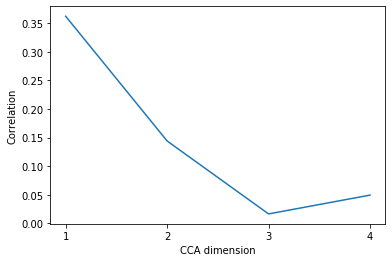

In [45]:
# bin spikes and get trial IDs associated with them
binned_spikes, binned_trialIDs = bin_spikes_trials(spikes, trials, T_BIN=0.01)

# extract 2 populations
data = [binned_spikes[:100, :].T, binned_spikes[100:200, :].T]

# preprocess data
for i, pop in enumerate(data):
    data[i] = preprocess(pop, n_pcs=PCA_DIMS, smoothing_sd=SMOOTH_SIZE)

# split trials
idxs_trial = split_trials(np.unique(binned_trialIDs), n_splits=N_SPLITS, rng_seed=RNG_SEED)
# get train/test indices into spike arrays
idxs_time = split_timepoints(binned_trialIDs, idxs_trial)

# fit cca
cca = fit_cca(
    data[0][idxs_time['train'], :], data[1][idxs_time['train'], :], n_cca_dims=CCA_DIMS)

# plot cca correlations
corrs = get_correlations(cca, data[0][idxs_time['test'], :], data[1][idxs_time['test'], :])
plot_correlations(corrs)

In [7]:
## Generate a matrix of correlations (biggest correlation found) between all pairwise areas
# bin spikes and get trial IDs associated with them
binned_spikes, binned_trialIDs = bin_spikes_trials(spikes, trials, T_BIN=0.01)
# split trials
idxs_trial = split_trials(np.unique(binned_trialIDs), n_splits=N_SPLITS, rng_seed=RNG_SEED)
# get train/test indices into spike arrays
idxs_time = split_timepoints(binned_trialIDs, idxs_trial)
# Define areas
brain_areas = np.unique(clusters.brainAcronyms)
# [subset for testing] DELETE
#brain_areas = brain_areas[1:4]

In [8]:
# Split/create populations
# bin_spikes_trials does not return info for innactive clusters
active_clusters = np.unique(spikes['clusters'])
split_binned_spikes = split_by_area(binned_spikes, clusters.brainAcronyms,
                                    active_clusters, brain_areas)

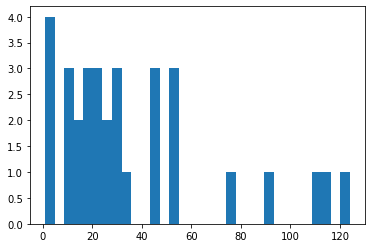

In [13]:
# plot a histogram of the number of neurons per region
clusters_per_brain_areas = [len(i) for i in split_binned_spikes]
plt.hist(clusters_per_brain_areas, bins=len(split_binned_spikes))
plt.show()

In [25]:
brain_areas = np.unique(clusters.brainAcronyms)

In [26]:
# select brain areas based on size of clusters and redo
cutoff = 60
brain_areas = brain_areas[np.array(clusters_per_brain_areas) > cutoff]
brain_areas

array(['APN', 'MRN', 'ProS', 'dhc', 'fp'], dtype=object)

In [27]:
# for testing
brain_areas = brain_areas[1:4]

In [28]:
# Create empty "matrix" to store cca objects
cca_mat = [[None for _ in range(len(brain_areas))] for _ in range(len(brain_areas))]

# For each pair of populations:
for i in range(len(brain_areas)):
    pop1 = split_binned_spikes[i].T
    for j in range(len(brain_areas)):
        if j > i:
            pop2 = split_binned_spikes[j].T
            # fit cca
            cca = fit_cca(
                pop1[idxs_time['train'], :], pop2[idxs_time['train'], :], n_cca_dims=CCA_DIMS)
            # populate matrix
            cca_mat[i][j] = cca
            # print progress
            print("{} / {}".format(i, j))

# Plot matrix

0 / 1
0 / 2
1 / 2


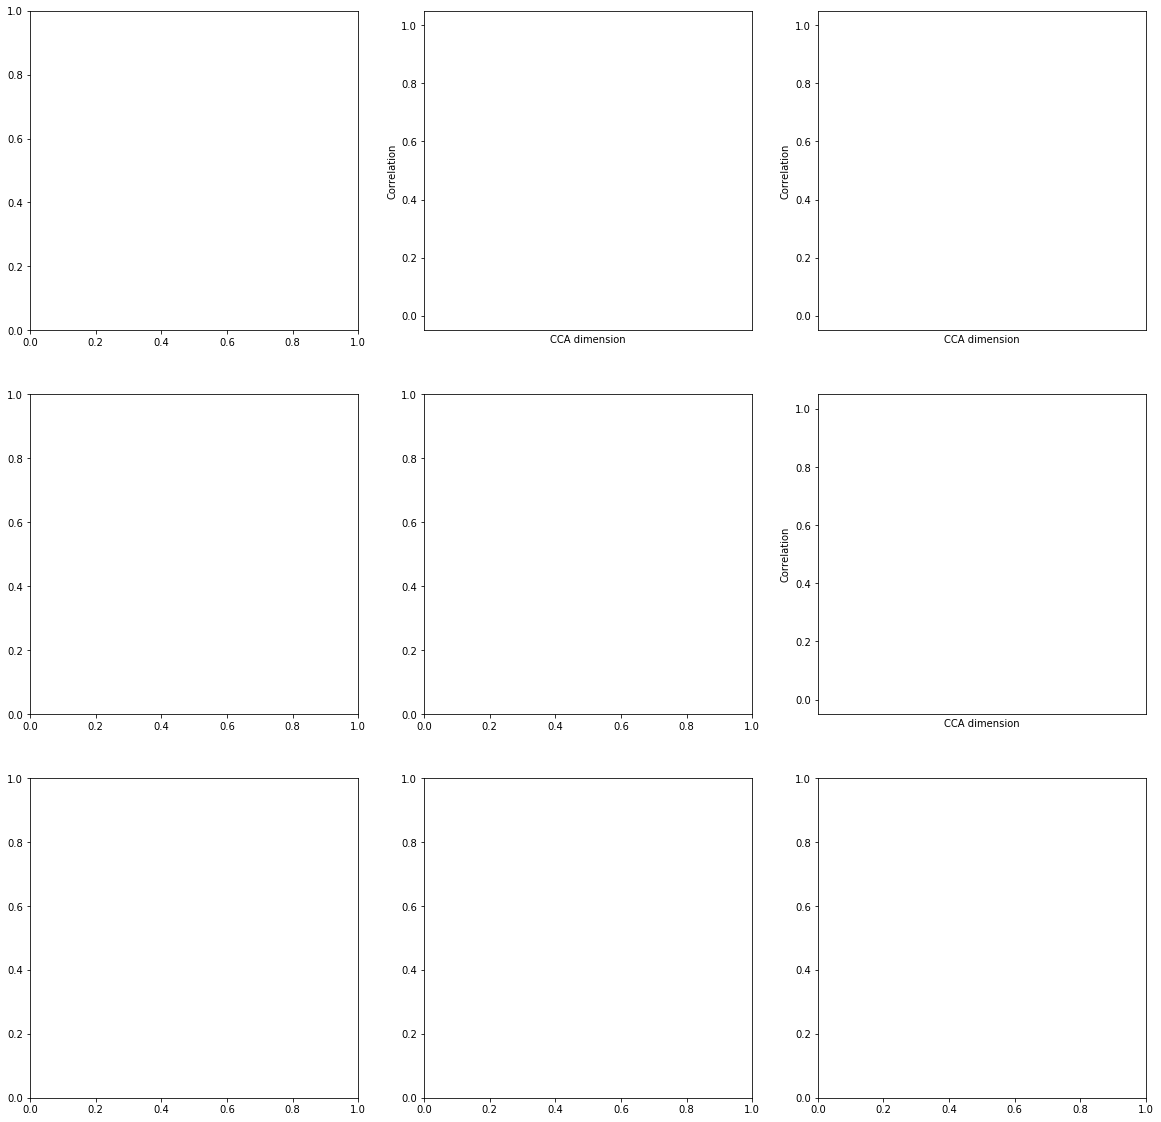

In [52]:
fig, axs = plt.subplots(len(cca_mat), len(cca_mat), figsize=(20,20))
#axs = axs.ravel()
# For each pair of populations:
for i in range(len(brain_areas)):
    pop1 = split_binned_spikes[i].T
    for j in range(len(brain_areas)):
        if j > i:
            pop2 = split_binned_spikes[j].T
            cca = cca_mat[i][j]
            corrs = get_correlations(cca, pop1[idxs_time['test'], :], pop2[idxs_time['test'], :])
            plot_correlations(corrs, ax=axs[i,j])
            

In [53]:
corrs

array([], dtype=float64)

In [55]:
cca.x_rotations_

array([[ 0.08563813, -0.03149587, -0.03261099,  0.14517447],
       [ 0.00448883,  0.11603699, -0.15259559, -0.02039569],
       [-0.0024175 , -0.02887181,  0.01902685, -0.01609408],
       [ 0.00273811,  0.43467314, -0.18589081,  0.03294841],
       [ 0.03959231, -0.15982196, -0.10222908,  0.3298401 ],
       [ 0.00229836,  0.06188066, -0.22803984,  0.09844801],
       [ 0.06044926,  0.00239072, -0.21720226,  0.12705204],
       [-0.01929744, -0.04236043,  0.02210209,  0.12198154],
       [-0.00826469,  0.14986998, -0.00389171, -0.06049296],
       [ 0.01153725,  0.04770261,  0.27327455, -0.00912408],
       [ 0.01135581,  0.19492001,  0.02787018, -0.03287718],
       [ 0.00404134,  0.54017275, -0.05919955,  0.14612371],
       [ 0.04954342, -0.19615283,  0.10893968, -0.32203872],
       [ 0.01800141,  0.03509569,  0.04578216,  0.11100221],
       [-0.02966641, -0.12341256, -0.16885372,  0.01822285],
       [-0.03117881, -0.02363782, -0.26750001, -0.08153614],
       [ 0.0405739 , -0.